In [1]:
#importing libraries
import cv2
from keras.models import load_model
import numpy as np
import os
import speech_recognition as sr
import moviepy.editor as mp
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input
from statistics import mode

In [3]:
# parameters for loading data and images
detection_model_path = 'trained_models/detection_models/haarcascade_frontalface_default.xml'
emotion_model_path = 'trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'
emotion_labels = get_labels('fer2013')

In [4]:
# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

In [5]:
# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

<h3>Sentimental analysis of the candidate</h3>


<h4>Detected:
    <ol>
    1. Angry
    2. Sad
    3. Happy
    4. Suprise
    5. Other</ol>
    </h4>
    
    
Note: Press Q to exit at end.    


In [6]:
# starting video streaming
angry = 0
sad = 0
happy = 0 
suprise = 0
other = 0
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture('Interview_4.mp4')
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)

    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        emotion_text = emotion_labels[emotion_label_arg]
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
            angry = angry + 1
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 0, 255))
            sad = sad + 1
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((255, 255, 0))
            happy = happy + 1
        elif emotion_text == 'surprise':
            color = emotion_probability * np.asarray((0, 255, 255))
            suprise = suprise + 1 
        else:
            color = emotion_probability * np.asarray((0, 255, 0))
            other = other + 1

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, emotion_mode,
                  color, 0, -45, 1, 1)

    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

<h3>Convert voice part of the answer and convert to text</h3>



<b>Pipeline:</b>

1. Convert video to audio : done using MoviePy

2. Using Sppech Recognizer convert generated audio to text

In [7]:
clip = mp.VideoFileClip(r'Interview_4.mp4') 
clip.audio.write_audiofile(r'converted.wav')

chunk:  30%|███       | 287/956 [00:00<00:00, 2866.73it/s, now=None]

MoviePy - Writing audio in converted.wav


MoviePy - Done.


In [8]:
r = sr.Recognizer()
audio = sr.AudioFile("converted.wav")

In [9]:
type(audio)

speech_recognition.AudioFile

In [10]:
with audio as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source,duration=120)
    # recognize (convert from speech to text)
    text = r.recognize_google(audio_data)
    print(text)

hello everyone my name is David Burke and I am doing master of data science from the University of Adelaide and I choose this field of study because I've always been interested in this field I have worked for the defence Industries and help them in automation using data science and I feel ready to take my career to the next level so that's why I am currently looking for a new apportionately and recording this video thank you


<h3>Identify most prominent sentiments based on the candidate’s face, e.g. happy, stressed, sad, etc.</h3>

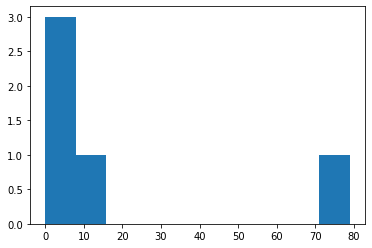

In [11]:
#can see using histogram
plt.hist([angry,sad,happy,suprise,other])
plt.show()

<h3>Identify various nonverbal attributes.</h3>

1. Detecing eyeballs and printing motion of eyeball to see if our candidate is confident or not
2. Press ESC to exit

In [12]:
eye_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_eye_tree_eyeglasses.xml')
face_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_alt.xml')

cap = cv2.VideoCapture('Interview_4.mp4')


while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     
    
    faces = face_cascade.detectMultiScale(
        gray, 
        scaleFactor = 1.1, 
        minNeighbors = 5,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        pupilFrame = roi_gray
        pupilO = roi_gray
        windowClose = np.ones((5,5),np.uint8)
        windowOpen = np.ones((2,2),np.uint8)
        windowErode = np.ones((2,2),np.uint8)
        
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            cv2.line(roi_color, (ex,ey), ((ex+ew,ey+eh)), (0,0,255),1)
            cv2.line(roi_color, (ex+ew,ey), ((ex,ey+eh)), (0,0,255),1)
            pupilFrame = cv2.equalizeHist(roi_gray[int(ey+(eh*.25)):(ey+eh), ex:(ex+ew)])
            pupilO = pupilFrame
            ret, pupilFrame = cv2.threshold(pupilFrame,50,255,cv2.THRESH_BINARY)        #50 ..nothin 70 is better
            pupilFrame = cv2.morphologyEx(pupilFrame, cv2.MORPH_CLOSE, windowClose)
            pupilFrame = cv2.morphologyEx(pupilFrame, cv2.MORPH_ERODE, windowErode)
            pupilFrame = cv2.morphologyEx(pupilFrame, cv2.MORPH_OPEN, windowOpen)

            threshold = cv2.inRange(pupilFrame,250,255)        #get the blobs

            contours, hierarchy = cv2.findContours(threshold,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) >= 2:
                    #find biggest blob
                    maxArea = 0
                    MAindex = 0            #to get the unwanted frame 
                    distanceX = []        #delete the left most (for right eye)
                    currentIndex = 0 
                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        center = cv2.moments(cnt)
                        if center['m00'] != 0:
                            cx = int(center["m10"] / center["m00"])
                            cy = int(center["m01"] / center["m00"])
                        else:
                            cx,cy = 0, 0
                        distanceX.append(cx)    
                        if area > maxArea:
                            maxArea = area
                            MAindex = currentIndex
                        currentIndex = currentIndex + 1

                    del contours[MAindex]        #remove the picture frame contour
                    del distanceX[MAindex]

            eye = 'right'

            if len(contours) >= 2:        #delete the left most blob for right eye
                if eye == 'right':
                    edgeOfEye = distanceX.index(min(distanceX))
                else:
                    edgeOfEye = distanceX.index(max(distanceX))    
                del contours[edgeOfEye]
                del distanceX[edgeOfEye]

            if len(contours) >= 1:        #get largest blob
                    maxArea = 0
                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        if area > maxArea:
                            maxArea = area
                            largeBlob = cnt

            if len(largeBlob) > 0:    
                    center = cv2.moments(largeBlob)
                    cx,cy = int(center['m10']/center['m00']), int(center['m01']/center['m00'])
                    cv2.circle(pupilO,(cx,cy),5,255,-1)
            
            cv2.imshow('Eye',pupilO)
            cv2.imshow('Eye1',pupilFrame)
            
    cv2.imshow('img',img)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()